In [ ]:
pip install deepxde

In [2]:
#approximate upper bound of range
#right bound of domain (used for scaling)

ub = 200
rb = 20

Compiling model...
Building feed-forward neural network...
'build' took 0.091964 s



/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


'compile' took 1.195113 s

Initializing variables...
Training model...

0         [2.44e+02, 1.42e+01, 0.00e+00, 0.00e+00]    [2.44e+02, 1.42e+01, 0.00e+00, 0.00e+00]    []  
INFO:tensorflow:model/model.ckpt-1 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model/model.ckpt-1 is not in all_model_checkpoint_paths. Manually adding it.


1000      [2.94e+00, 4.35e-01, 0.00e+00, 0.00e+00]    [2.99e+00, 4.37e-01, 0.00e+00, 0.00e+00]    []  
INFO:tensorflow:model/model.ckpt-1000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model/model.ckpt-1000 is not in all_model_checkpoint_paths. Manually adding it.


2000      [1.83e+00, 6.32e-01, 0.00e+00, 0.00e+00]    [1.87e+00, 6.37e-01, 0.00e+00, 0.00e+00]    []  
INFO:tensorflow:model/model.ckpt-2000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model/model.ckpt-2000 is not in all_model_checkpoint_paths. Manually adding it.


3000      [1.26e+00, 5.40e-01, 0.00e+00, 0.00e+00]    [1.28e+00, 5.45e-01, 0.00e+00, 0.00e+00]    []  
INFO:tensorflow:model/model.ckpt-3000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model/model.ckpt-3000 is not in all_model_checkpoint_paths. Manually adding it.


4000      [1.01e+00, 3.92e-01, 0.00e+00, 0.00e+00]    [1.03e+00, 3.94e-01, 0.00e+00, 0.00e+00]    []  
INFO:tensorflow:model/model.ckpt-4000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model/model.ckpt-4000 is not in all_model_checkpoint_paths. Manually adding it.


5000      [6.71e-01, 3.47e-01, 0.00e+00, 0.00e+00]    [6.88e-01, 3.51e-01, 0.00e+00, 0.00e+00]    []  
INFO:tensorflow:model/model.ckpt-5000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model/model.ckpt-5000 is not in all_model_checkpoint_paths. Manually adding it.


6000      [5.05e-01, 3.16e-01, 0.00e+00, 0.00e+00]    [5.19e-01, 3.20e-01, 0.00e+00, 0.00e+00]    []  
INFO:tensorflow:model/model.ckpt-6000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model/model.ckpt-6000 is not in all_model_checkpoint_paths. Manually adding it.


7000      [3.66e-01, 2.80e-01, 0.00e+00, 0.00e+00]    [3.76e-01, 2.84e-01, 0.00e+00, 0.00e+00]    []  
INFO:tensorflow:model/model.ckpt-7000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model/model.ckpt-7000 is not in all_model_checkpoint_paths. Manually adding it.


8000      [2.32e-01, 2.31e-01, 0.00e+00, 0.00e+00]    [2.38e-01, 2.34e-01, 0.00e+00, 0.00e+00]    []  
INFO:tensorflow:model/model.ckpt-8000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model/model.ckpt-8000 is not in all_model_checkpoint_paths. Manually adding it.


9000      [1.32e-01, 1.69e-01, 0.00e+00, 0.00e+00]    [1.35e-01, 1.71e-01, 0.00e+00, 0.00e+00]    []  
INFO:tensorflow:model/model.ckpt-9000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model/model.ckpt-9000 is not in all_model_checkpoint_paths. Manually adding it.


10000     [6.69e-02, 1.22e-01, 0.00e+00, 0.00e+00]    [6.77e-02, 1.24e-01, 0.00e+00, 0.00e+00]    []  
INFO:tensorflow:model/model.ckpt-10000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model/model.ckpt-10000 is not in all_model_checkpoint_paths. Manually adding it.


11000     [5.31e-02, 8.48e-02, 0.00e+00, 0.00e+00]    [5.32e-02, 8.59e-02, 0.00e+00, 0.00e+00]    []  
INFO:tensorflow:model/model.ckpt-11000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model/model.ckpt-11000 is not in all_model_checkpoint_paths. Manually adding it.


12000     [3.73e-02, 6.62e-02, 0.00e+00, 0.00e+00]    [3.72e-02, 6.70e-02, 0.00e+00, 0.00e+00]    []  
INFO:tensorflow:model/model.ckpt-12000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model/model.ckpt-12000 is not in all_model_checkpoint_paths. Manually adding it.


13000     [2.98e-02, 5.43e-02, 0.00e+00, 0.00e+00]    [2.97e-02, 5.50e-02, 0.00e+00, 0.00e+00]    []  
INFO:tensorflow:model/model.ckpt-13000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model/model.ckpt-13000 is not in all_model_checkpoint_paths. Manually adding it.


14000     [7.53e-02, 2.24e-01, 0.00e+00, 0.00e+00]    [7.52e-02, 2.24e-01, 0.00e+00, 0.00e+00]    []  
15000     [2.33e-02, 3.58e-02, 0.00e+00, 0.00e+00]    [2.33e-02, 3.59e-02, 0.00e+00, 0.00e+00]    []  
INFO:tensorflow:model/model.ckpt-15000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model/model.ckpt-15000 is not in all_model_checkpoint_paths. Manually adding it.


16000     [4.59e-02, 2.47e-02, 0.00e+00, 0.00e+00]    [4.59e-02, 2.48e-02, 0.00e+00, 0.00e+00]    []  
17000     [1.48e-02, 1.75e-02, 0.00e+00, 0.00e+00]    [1.47e-02, 1.75e-02, 0.00e+00, 0.00e+00]    []  
INFO:tensorflow:model/model.ckpt-17000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model/model.ckpt-17000 is not in all_model_checkpoint_paths. Manually adding it.


18000     [1.33e-02, 1.20e-02, 0.00e+00, 0.00e+00]    [1.32e-02, 1.20e-02, 0.00e+00, 0.00e+00]    []  
INFO:tensorflow:model/model.ckpt-18000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model/model.ckpt-18000 is not in all_model_checkpoint_paths. Manually adding it.


19000     [1.25e-02, 1.43e-02, 0.00e+00, 0.00e+00]    [1.25e-02, 1.43e-02, 0.00e+00, 0.00e+00]    []  
20000     [1.77e-02, 2.89e-02, 0.00e+00, 0.00e+00]    [1.77e-02, 2.89e-02, 0.00e+00, 0.00e+00]    []  
21000     [8.98e-03, 1.31e-02, 0.00e+00, 0.00e+00]    [8.97e-03, 1.31e-02, 0.00e+00, 0.00e+00]    []  
INFO:tensorflow:model/model.ckpt-21000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model/model.ckpt-21000 is not in all_model_checkpoint_paths. Manually adding it.


22000     [1.33e-02, 8.50e-03, 0.00e+00, 0.00e+00]    [1.33e-02, 8.51e-03, 0.00e+00, 0.00e+00]    []  
INFO:tensorflow:model/model.ckpt-22000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model/model.ckpt-22000 is not in all_model_checkpoint_paths. Manually adding it.


23000     [5.28e-03, 5.93e-03, 0.00e+00, 0.00e+00]    [5.28e-03, 5.93e-03, 0.00e+00, 0.00e+00]    []  
INFO:tensorflow:model/model.ckpt-23000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model/model.ckpt-23000 is not in all_model_checkpoint_paths. Manually adding it.


24000     [1.58e-02, 6.07e-03, 0.00e+00, 0.00e+00]    [1.57e-02, 6.07e-03, 0.00e+00, 0.00e+00]    []  
25000     [1.21e-02, 4.14e-03, 0.00e+00, 0.00e+00]    [1.21e-02, 4.14e-03, 0.00e+00, 0.00e+00]    []  
26000     [3.27e-03, 3.65e-03, 0.00e+00, 0.00e+00]    [3.27e-03, 3.65e-03, 0.00e+00, 0.00e+00]    []  
INFO:tensorflow:model/model.ckpt-26000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model/model.ckpt-26000 is not in all_model_checkpoint_paths. Manually adding it.


27000     [2.06e-02, 4.08e-02, 0.00e+00, 0.00e+00]    [2.06e-02, 4.08e-02, 0.00e+00, 0.00e+00]    []  
28000     [1.64e-02, 9.27e-03, 0.00e+00, 0.00e+00]    [1.64e-02, 9.27e-03, 0.00e+00, 0.00e+00]    []  
29000     [8.50e-02, 1.06e-01, 0.00e+00, 0.00e+00]    [8.51e-02, 1.06e-01, 0.00e+00, 0.00e+00]    []  
30000     [2.95e-03, 3.17e-03, 0.00e+00, 0.00e+00]    [2.95e-03, 3.17e-03, 0.00e+00, 0.00e+00]    []  
INFO:tensorflow:model/model.ckpt-30000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model/model.ckpt-30000 is not in all_model_checkpoint_paths. Manually adding it.


31000     [3.61e-03, 3.54e-03, 0.00e+00, 0.00e+00]    [3.60e-03, 3.55e-03, 0.00e+00, 0.00e+00]    []  
32000     [2.98e-02, 1.63e-02, 0.00e+00, 0.00e+00]    [2.97e-02, 1.63e-02, 0.00e+00, 0.00e+00]    []  
33000     [2.16e-03, 2.04e-03, 0.00e+00, 0.00e+00]    [2.16e-03, 2.04e-03, 0.00e+00, 0.00e+00]    []  
INFO:tensorflow:model/model.ckpt-33000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model/model.ckpt-33000 is not in all_model_checkpoint_paths. Manually adding it.


34000     [8.06e-03, 2.70e-03, 0.00e+00, 0.00e+00]    [8.07e-03, 2.70e-03, 0.00e+00, 0.00e+00]    []  
35000     [6.63e-02, 1.01e-02, 0.00e+00, 0.00e+00]    [6.64e-02, 1.01e-02, 0.00e+00, 0.00e+00]    []  
36000     [2.71e-03, 4.11e-03, 0.00e+00, 0.00e+00]    [2.71e-03, 4.11e-03, 0.00e+00, 0.00e+00]    []  
37000     [6.39e-03, 4.80e-03, 0.00e+00, 0.00e+00]    [6.40e-03, 4.79e-03, 0.00e+00, 0.00e+00]    []  
38000     [2.38e-02, 1.74e-02, 0.00e+00, 0.00e+00]    [2.37e-02, 1.74e-02, 0.00e+00, 0.00e+00]    []  
39000     [1.38e-03, 1.47e-03, 0.00e+00, 0.00e+00]    [1.38e-03, 1.47e-03, 0.00e+00, 0.00e+00]    []  
INFO:tensorflow:model/model.ckpt-39000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model/model.ckpt-39000 is not in all_model_checkpoint_paths. Manually adding it.


40000     [1.82e-03, 1.54e-03, 0.00e+00, 0.00e+00]    [1.82e-03, 1.54e-03, 0.00e+00, 0.00e+00]    []  
41000     [7.53e-03, 5.00e-03, 0.00e+00, 0.00e+00]    [7.52e-03, 5.00e-03, 0.00e+00, 0.00e+00]    []  
42000     [1.03e-02, 2.94e-03, 0.00e+00, 0.00e+00]    [1.03e-02, 2.93e-03, 0.00e+00, 0.00e+00]    []  
43000     [1.63e-03, 1.41e-03, 0.00e+00, 0.00e+00]    [1.62e-03, 1.41e-03, 0.00e+00, 0.00e+00]    []  
44000     [1.13e-03, 1.05e-03, 0.00e+00, 0.00e+00]    [1.13e-03, 1.05e-03, 0.00e+00, 0.00e+00]    []  
INFO:tensorflow:model/model.ckpt-44000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model/model.ckpt-44000 is not in all_model_checkpoint_paths. Manually adding it.


45000     [1.07e-03, 1.01e-03, 0.00e+00, 0.00e+00]    [1.07e-03, 1.01e-03, 0.00e+00, 0.00e+00]    []  
INFO:tensorflow:model/model.ckpt-45000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model/model.ckpt-45000 is not in all_model_checkpoint_paths. Manually adding it.


46000     [1.34e-02, 7.37e-03, 0.00e+00, 0.00e+00]    [1.34e-02, 7.36e-03, 0.00e+00, 0.00e+00]    []  
47000     [1.20e-03, 1.11e-03, 0.00e+00, 0.00e+00]    [1.20e-03, 1.11e-03, 0.00e+00, 0.00e+00]    []  
48000     [1.17e-03, 1.09e-03, 0.00e+00, 0.00e+00]    [1.17e-03, 1.08e-03, 0.00e+00, 0.00e+00]    []  
49000     [1.82e-03, 1.17e-03, 0.00e+00, 0.00e+00]    [1.82e-03, 1.16e-03, 0.00e+00, 0.00e+00]    []  
50000     [3.64e-03, 1.70e-03, 0.00e+00, 0.00e+00]    [3.64e-03, 1.70e-03, 0.00e+00, 0.00e+00]    []  

Best model at step 45000:
  train loss: 2.08e-03
  test loss: 2.08e-03
  test metric: []

'train' took 378.940370 s

INFO:tensorflow:Restoring parameters from model/model.ckpt-45000


INFO:tensorflow:Restoring parameters from model/model.ckpt-45000


Compiling model...
'compile' took 0.951553 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
50000     [1.07e-03, 1.01e-03, 0.00e+00, 0.00e+00]    [1.07e-03, 1.01e-03, 0.00e+00, 0.00e+00]    []  
51000     [3.83e-05, 3.87e-05, 0.00e+00, 0.00e+00]                                                    
52000     [1.34e-05, 1.05e-05, 0.00e+00, 0.00e+00]                                                    
53000     [7.77e-06, 5.84e-06, 0.00e+00, 0.00e+00]                                                    
54000     [4.62e-06, 4.28e-06, 0.00e+00, 0.00e+00]                                                    
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 0.000008
  Number of iterations: 4077
  Number of functions evaluations: 4499


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 0.000008
  Number of iterations: 4077
  Number of functions evaluations: 4499


54499     [4.00e-06, 3.79e-06, 0.00e+00, 0.00e+00]    [4.04e-06, 3.79e-06, 0.00e+00, 0.00e+00]    []  

Best model at step 54499:
  train loss: 7.79e-06
  test loss: 7.82e-06
  test metric: []

'train' took 220.453166 s

Saving loss history to loss.dat ...
Saving training data to train.dat ...
Saving test data to test.dat ...


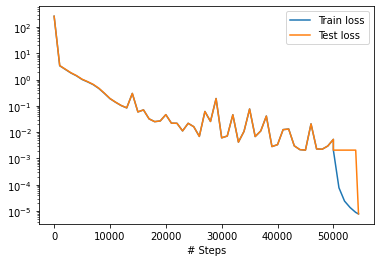

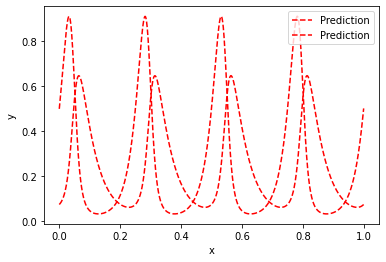

In [26]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import math 
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import deepxde as dde

def ode_system(x, y):
    r = y[:, 0:1]
    p = y[:, 1:2]
    dr_t = dde.grad.jacobian(y,x, i=0)
    dp_t = dde.grad.jacobian(y,x, i=1)
    return [
        dr_t - 1/ub * rb* (2.* ub * r - .04 * ub * r * ub *p),
        dp_t - 1/ub * rb * (.02 * r * ub * p * ub - 1.06 * p* ub)
    ]

def boundary(_, on_initial):
    return on_initial

geom = dde.geometry.TimeDomain(0., 1.)
ic1 = dde.IC(geom, lambda _: np.full(1, 100/ub), boundary, component=0)
ic2 = dde.IC(geom, lambda _: np.full(1, 15/ub), boundary, component=1)
data = dde.data.PDE(
    geom, ode_system, [ic1, ic2], 3000, 2, "sobol", num_test= 3000
)

layer_size = [1] + [64] * 6  + [2]
activation = "tanh"
initializer = "Glorot normal"
net = dde.maps.FNN(layer_size, activation, initializer)

def input_transform(t):
  return tf.concat((t, tf.sin(t), tf.sin(2*t), tf.sin(3*t), tf.sin(4*t), tf.sin(5*t), tf.sin(6*t)), axis = 1)

def output_transform(t, y):
    y1 = y[:, 0:1]
    y2 = y[:, 1:2]
    
    return tf.concat((y1*tf.math.tanh(t)+100/ub, y2*tf.math.tanh(t)+15/ub), axis=1)

net.apply_feature_transform(input_transform)
net.apply_output_transform(output_transform)

es = dde.callbacks.EarlyStopping(patience = 5000)

checkpointer = dde.callbacks.ModelCheckpoint(
        "model/model.ckpt", verbose=0, save_better_only=True
    )

model = dde.Model(data, net)
model.compile("adam", lr=0.001)
losshistory, train_state = model.train(epochs=50000, callbacks = [checkpointer])

model.restore("model/model.ckpt-" + str(train_state.best_step))
model.compile('L-BFGS-B')
model.train()

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

Predicting...
'predict' took 0.091457 s



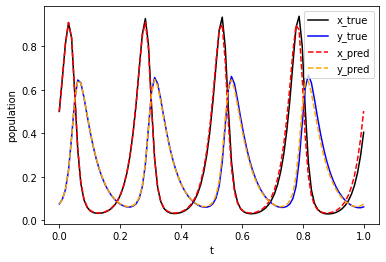

L2 relative error for x: 0.08116196378464366
L2 relative error for y: 0.05519780977717557


In [27]:
from scipy import integrate
import numpy as np
import matplotlib.pyplot as plt

def func(t,r):
    x,y = r
    dx_ = 1/ub * rb*(2.*ub*x - .04 * ub*x *ub*y)
    fy = 1/ub * rb*(.02 * ub*x * ub*y - 1.06 * ub*y)
    return fx, fy

t = np.linspace(0,1,100)

sol = integrate.solve_ivp(f, (0,10), (100/ub,15/ub), t_eval = t)
x_true,y_true= sol.y
x_true = x_true.reshape(100,1)
y_true = y_true.reshape(100,1)
plt.plot(t,x_true, color = "black", label = "x_true")
plt.plot(t,y_true, color = "blue", label = "y_true")

t = t.reshape(100, 1)
sol_pred = model.predict(t)
x_pred = sol_pred[:, 0:1]
y_pred = sol_pred[:, 1:2]

plt.xlabel('t')
plt.ylabel('population')
plt.plot(t, x_pred, color = "red", linestyle = "dashed", label = "x_pred")
plt.plot(t, y_pred, color = "orange", linestyle = "dashed", label = "y_pred")
plt.legend()
plt.show()


print("L2 relative error for x:", dde.metrics.l2_relative_error(x_true, x_pred))
print("L2 relative error for y:", dde.metrics.l2_relative_error(y_true, y_pred))